Extractive Summarizer: An extractive summarizer based on a non-deep learning supervised model.
1. In particular, you have to train a non-deep learning classification (e.g. logistic regression, SVM) or regression model (e.g. ElasticNet, SVR) that will be used for scoring the sentences of the input document. (0 or 1)
2. Then based on the scores you will create a summarizer that attempts to create a summary with the most informative, non-redundant **sentences**. It is up to you which machine learning model and features you will use.


#Steps

1.Preprocessing , which will be applied also on the highlights: so the 2 new columns cleaned_articles, cleaned highlights will be use for similarity calculation and feature extraction.
2. Feature Extraction (sentence length, sentence position): here also we can try : NER the count of **Named entities** in a sentence , and POS tagging for the count of **VERBS ** (since Verbs can denote events, it can also good practice for event extraction)
3. Sentence similarity calculation: similarity of each sentence of the article with each sentence in the highlights based on their Average word2vec embedding.
 High scores between pairs denote that the sentence is a good candidate for being added in the summary, so high-scoring sentences will be assigned label 1. Low scoring pairs based on a specific threshold will be assigned label 0.
4. Sentence extraction: extract the n first sentences in the document that have been given a value of 1 in the previous step. (i chose the 3 first)
5. Summary production: these 3 first sentences should be written in a .txt file , where on the left side, we will have the article id: eg
(f001ec5c4704938247d27a44948eebb37ae98d01) and then the 3 extracted sentences as raw text,separated with a fullstop (no lists).
6. the content of 'highlights' column should be compared to the content of the 'ml-summary' column and Compute Rouge 2 metrics in a new column which will contain all 3 requested metrics in a dictionary

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tst.head()

In [ ]:
!pip install datasets contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import datasets
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import numpy as np

In [ ]:
# Specify the dataset name and version
dataset_name = "cnn_dailymail"
dataset_version = "3.0.0"

# Load a specific version of the dataset from Hugging Face
dataset = datasets.load_dataset(dataset_name, dataset_version)

# Convert the dataset to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])  # You can use 'train', 'test', or 'validation'
df.to_csv('train.csv')
#df =pd.read_csv('/content/output_file.csv')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
df =pd.read_csv('/content/train.csv')
df_train=df.head(1000)


In [ ]:
df_train

,Unnamed: 0,article,highlights,id
0,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
...,...,...,...,...
995,995,The mother of murdered schoolboy Damilola Tayl...,Mother of murdered schoolboy Damilola Taylor d...,2930e1a7ac24bce649bfbf5f5971e74515e38a0a
996,996,WASHINGTON (CNN) -- A smiling Pope Benedict XV...,NEW: Pope Benedict XVI arrives in Washington f...,f5f7571a69e96c1d288d939861b7216c2bdc0ae4
997,997,(CNN) -- Eight Florida teenagers -- six of the...,Eight Florida teens to be tried as adults in v...,5f02aa32bd1dc95e47355755398e31550b232f8a
998,998,(CNN) -- The following are excerpts from the H...,Judge on Heather Mills: Level of premarital we...,9177e5ac94f038749e8d4eb526a65461e0f6df4c


#Preprocessing steps:
Remove:
- start and end patterns
- parenthesis (and everything insinde them)

##Also another pattern spotted in the highlights column: NEW: blablaaa , so remove the "NEW:" at the beginning of the highlights
- expand contractions (won't =will not)
- stopwords
- 's (sister's =sister)
- sentence tokenization
- lowercasing
- word tokenisation
- remove punctuation
- non- ascii characters (e.g $ 20 million= 20 million)
- lemmatization  

**What was not removed and maybe it should be removed is the numbers!!**)

#Also more cleaning to DO!!!:
1. Drop the duplicate rows
2. Check & Remove Null data
3. Remove https, links, urls,
4. remove href:..

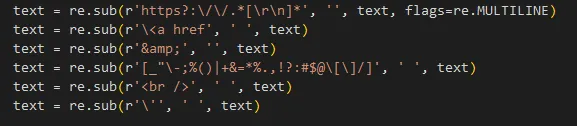

In [ ]:

def apply_lemmatization(tokens):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(word) for word in tokens]

def apply_stemming(tokens):
  porter = PorterStemmer()
  return [porter.stem(word) for word in tokens]

def clean_text(x):
  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#',
              '*', '+', '\\', '•', '~', '@', '£',
              '·', '_', '{', '}', '©', '^', '®', '`','--', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â',
              '█', '½', 'à', '…',
              '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―',
              '¥', '▓', '—', '‹', '─',
              '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸',
              '¾', 'Ã', '⋅', '‘', '∞',
              '∙', '）', '↓', '、', '│', '（', '»','«', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
              '¹', '≤', '‡', '√', ]

  x = str(x)
  for punct in puncts:
    x = x.replace(punct, f' {punct} ')
  return x

def remove_non_ascii(tokens):
    return [word for word in tokens if re.match(r'^[^\x00-\x7F]+$', word) is None]

def clean_and_tokenize(article):
    # Remove text within parentheses and everything in it
    cleaned_article = re.sub(r'\([^)]*\)', '', article)

    # Split the text using '-- ' as the delimiter
    parts = re.split(r'-- ', cleaned_article, maxsplit=1)

    # Check if there was a match and reconstruct the text
    cleaned_article = parts[1] if len(parts) > 1 else cleaned_article

    # Remove 'E-mail to a friend' and anything that follows it
    cleaned_article = re.sub(r'E-mail to a friend.*', '', cleaned_article)

    # Expand word contractions
    expanded_article = contractions.fix(cleaned_article)
    # Add a period after the closing quotation mark if there is a space and a capital letter
    text_with_period = re.sub(r'(")([ ])([A-Z])', r'\1.\2\3', expanded_article)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text_with_period)
    filtered_article = [word for word in word_tokens if word.lower() not in stop_words and word.lower() != "'s"]

    filtered_article = ' '.join(filtered_article)

    sentences = sent_tokenize(filtered_article)

    # Tokenize sentences
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    # Remove punctuation using custom clean_text function
    tokenized_sentences_no_punct = [
        [word for word in word_tokenize(clean_text(sentence)) if word not in string.punctuation]
        for sentence in sentences]
    tokenized_sentences_no_ascii = [
    remove_non_ascii(sentence)
    for sentence in tokenized_sentences_no_punct]
    # Apply lemmatization
    tokenized_sentences_lemmatized = [
        apply_lemmatization(sentence)
        for sentence in tokenized_sentences_no_ascii]

    # Remove empty lists
    tokenized_sentences_lemmatized = [sentence for sentence in tokenized_sentences_lemmatized if sentence]
    #returns for each row a list of lists, separated by comma)
    return tokenized_sentences_lemmatized

# Apply the function to each row in the 'article' column
df_train['cleaned_article'] = df_train['article'].apply(clean_and_tokenize)


In [ ]:
df_train['clean_highlights']=df_train['highlights'].apply(clean_and_tokenize)

<ipython-input-15-3a5e14523fe9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_highlights']=df_train['highlights'].apply(clean_and_tokenize)


In [ ]:
#df_train['first_half_sentences'] = df_train['cleaned_article'].apply(lambda sentences: sentences[:len(sentences)//2])
#df_test['first_half_sentences'] = df_test['cleaned_article'].apply(lambda sentences: sentences[:len(sentences)//2])

In [ ]:
len(df_train['cleaned_article'][0])

22

In [ ]:
rows_to_display = [0,1,2]  # Replace with the row indices you want to check

for row_index in rows_to_display:
    print(f"Row {row_index}:")
    print(df_train['cleaned_article'].iloc[row_index])
    print("\n---\n")

Row 0:
[['Harry', 'Potter', 'star', 'Daniel', 'Radcliffe', 'gain', 'access', 'reported', '20', 'million', 'fortune', 'turn', '18', 'Monday', 'insists', 'money', 'cast', 'spell'], ['Daniel', 'Radcliffe', 'Harry', 'Potter', 'Harry', 'Potter', 'Order', 'Phoenix'], ['disappointment', 'gossip', 'columnist', 'around', 'world', 'young', 'actor', 'say', 'plan', 'fritter', 'cash', 'away', 'fast', 'car', 'drink', 'celebrity', 'party'], ['plan', 'one', 'people', 'soon', 'turn', '18', 'suddenly', 'buy', 'massive', 'sport', 'car', 'collection', 'something', 'similar', 'told', 'Australian', 'interviewer', 'earlier', 'month'], ['think', 'particularly', 'extravagant'], ['thing', 'like', 'buying', 'thing', 'cost', '10', 'pound', 'book', 'CDs', 'DVDs'], ['18', 'Radcliffe', 'able', 'gamble', 'casino', 'buy', 'drink', 'pub', 'see', 'horror', 'film', 'Hostel', 'Part', 'II', 'currently', 'six', 'place', 'number', 'one', 'movie', 'UK', 'box', 'office', 'chart'], ['Details', 'mark', 'landmark', 'birthday', 'w

This code is for calculating the cosine similarity based on word counts it encodes information for each sentence in the row of the article.

It was not very effective because some articles had 0 value.

I did **not** use the CountVectorizer in the experiments, it was for checking if it works and what it outputs.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def compute_max_cosine_similarity(row, threshold=0.3):
    articles = row['cleaned_article']
    highlights = row['clean_highlights']

    # Flatten the lists of tokenized sentences into strings
    articles_str = [' '.join(sent) for sent in articles]
    highlights_str = [' '.join(sent) for sent in highlights]

    # Combine articles and highlights for fitting CountVectorizer
    all_sentences = articles_str + highlights_str

    # Use CountVectorizer to convert sentences to document-term matrices
    vectorizer = CountVectorizer()
    all_matrix = vectorizer.fit_transform(all_sentences).toarray()

    # Split the matrices back into articles and highlights parts
    articles_matrix = all_matrix[:len(articles)]
    highlights_matrix = all_matrix[len(articles):]

    # Compute cosine similarity for each pair of sentences
    similarity_matrix = cosine_similarity(articles_matrix, highlights_matrix)

    # Find the maximum similarity score for each sentence
    max_similarity_scores = similarity_matrix.max(axis=1)
    max_similarity_scores = [round(score, 3) for score in max_similarity_scores]
    # Assign labels based on the threshold
    labels = [1 if score >= threshold else 0 for score in max_similarity_scores]
    return labels

# Apply the compute_max_cosine_similarity function to each row
#df_train['max_cosine_similarity'] = df_train.apply(compute_max_cosine_similarity, axis=1)

df_train['labels'] = df_train.apply(compute_max_cosine_similarity, axis=1)

In [ ]:
df5=df_train.labels

In [ ]:
df7=df_train.max_cosine_similarity
df7

0    [0.64, 0.522, 0.642, 0.138, 0.0, 0.0, 0.136, 0...
1    [0.259, 0.064, 0.314, 0.22, 0.157, 0.114, 0.20...
2    [0.196, 0.067, 0.679, 0.0, 0.16, 0.0, 0.08, 0....
3    [0.5, 0.167, 0.0, 0.126, 0.408, 0.5, 0.154, 0....
4    [0.445, 0.471, 0.169, 0.218, 0.129, 0.267, 0.2...
5    [0.118, 0.123, 0.224, 0.144, 0.139, 0.258, 0.0...
6    [0.158, 0.149, 0.158, 0.169, 0.28, 0.169, 0.09...
7    [0.447, 0.679, 0.424, 0.41, 0.589, 0.577, 0.75...
8    [0.363, 0.381, 0.218, 0.426, 0.373, 0.0, 0.167...
9    [0.4, 0.142, 0.0, 0.522, 0.0, 0.123, 0.111, 0....
Name: max_cosine_similarity, dtype: object

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the entire DataFrame
df5

0    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...
7    [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...
8    [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...
9        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: labels, dtype: object

In [ ]:
df5.to_csv('cosine_sims_countvectorizer.csv')

In [ ]:
df5=pd.read_csv('cosine_sims_countvectorizer.csv')

#Explode dataframe:
Why explode??
My idea is that we are doing sentence based feature extraction.
Also the dataframe in the experiment we saw on github follow the same logic, at least that's what i understood.
Because in each  row of the test set we  have the information in the column article_sentence: see below

Check the example datasets, you see there is a column named :"article_sentence" and in each row of the test set : 1-0 ((1)1st article - (0)index of 1st sentence) and so on.

In [ ]:
#tr=pd.read_csv('/content/drive/MyDrive/NLU/Task_2/Training_Data_Extension_3.csv')
#tst=pd.read_csv('/content/drive/MyDrive/NLU/Task_2/Test_Data_Extension_3.csv')
#tr.head()
#tst.head()

In [ ]:
# Explode the DataFrame and reset the index
#df_train_exploded = df_train.explode('first_half_sentences').reset_index(drop=True)
#df_test_exploded = df_test.explode('first_half_sentences').reset_index(drop=True)

# Rename the 'articles' column to 'sentences'
#df_train_exploded = df_train_exploded.rename(columns={'first_half_sentences': 'sentences'})
#df_test_exploded = df_test_exploded.rename(columns={'first_half_sentences': 'sentences'})

# Display the resulting DataFrame
#print(df_train_exploded)
#print(df_test_exploded)

#Explodes the sentences of the cleaned article, but if we decide to keep only the first half sentences of each article, we have to change the 'cleaned_article' below with the 'first_half_sentences'

Another idea here, since the dataset is huge, is to only consider in the  dataset, articles which have only 200 words length of article and 50 words of summary (Due to limited hardware resources available): see this medium link [Feature selection](https://medium.com/@zayedrais/text-summarization-with-deep-learning-technique-part-1-d9882d40856a)

Says he is left with 28.000 articles.

In [ ]:
# Explode the DataFrame and reset the index
df_exploded = df_train.explode('cleaned_article').reset_index(drop=True)

# Rename the 'articles' column to 'sentences'
df_exploded = df_exploded.rename(columns={'cleaned_article': 'sentences'})

# Display the resulting DataFrame
print(df_exploded)

       Unnamed: 0                                            article  \
0               0  LONDON, England (Reuters) -- Harry Potter star...   
1               0  LONDON, England (Reuters) -- Harry Potter star...   
2               0  LONDON, England (Reuters) -- Harry Potter star...   
3               0  LONDON, England (Reuters) -- Harry Potter star...   
4               0  LONDON, England (Reuters) -- Harry Potter star...   
...           ...                                                ...   
32804         999  (Mental Floss) -- There have been presidential...   
32805         999  (Mental Floss) -- There have been presidential...   
32806         999  (Mental Floss) -- There have been presidential...   
32807         999  (Mental Floss) -- There have been presidential...   
32808         999  (Mental Floss) -- There have been presidential...   

                                              highlights  \
0      Harry Potter star Daniel Radcliffe gets £20M f...   
1      Harry Po

In [ ]:
df_exploded

#Encode sentence position:
Now that each sentence of each article is represented in a separate row, we can encode the position. 1 for thefirst sentence of each article- 0 for the last sentnece of each article. All the inbetween are gradually reduced towards the last sentence.

In [ ]:
# Assuming df_exploded is your DataFrame with the 'sentences' column
# and each article has a unique identifier column, let's call it 'article_id'

# Add a new column 'position' based on the sentences' order within each article
df_exploded['position'] = df_exploded.groupby('id').cumcount()

# Calculate the total number of sentences for each article
article_lengths = df_exploded.groupby('id').size()

# Gradually reduce the position value for each article
df_exploded['position'] = 1 - (df_exploded['position'] / article_lengths[df_exploded['id']].values)

## Add a new column 'position' based on the sentences' order within each article
#df_train_exploded['position'] = df_train_exploded.groupby('id').cumcount()
#df_test_exploded['position'] = df_test_exploded.groupby('id').cumcount()

# Calculate the total number of sentences for each article
#train_article_lengths = df_train_exploded.groupby('id').size()
#test_article_lengths = df_test_exploded.groupby('id').size()

# Gradually reduce the position value for each article
#df_train_exploded['position'] = 1 - (df_train_exploded['position'] / train_article_lengths[df_train_exploded['id']].values)
#df_test_exploded['position'] = 1 - (df_test_exploded['position'] / test_article_lengths[df_test_exploded['id']].values)

In [ ]:
# If you want to round the values to a certain decimal place, you can use round()
df_exploded['position'] = round(df_exploded['position'], 2)

In [ ]:
df_exploded.position

In [ ]:
df_text=df_exploded['sentences']

W2V: big issue now working properly!

In [ ]:
model_w2v=Word2Vec.load("/content/drive/MyDrive/NLU/Task_2/w2v_model/w2v_summ.model")

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

def find_words_in_w2v(train_dataset, w2vmodel):
    # Load the Word2Vec model
    if isinstance(w2vmodel, str):
        w2v_model = KeyedVectors.load_word2vec_format(w2vmodel, binary=True)
    elif isinstance(w2vmodel, Word2Vec):
        w2v_model = w2vmodel
    else:
        raise ValueError("Invalid Word2Vec model format")

    # Get the size of the Word2Vec model
    embedding_size = w2v_model.vector_size

    # Initialize an empty array to store mean embeddings
    mean_embeddings = []

    # Iterate over each row in the train_dataset
    for sentence in train_dataset['sentences']:
        # Initialize a list to store word embeddings in the current sentence
        word_embeddings = []

        # Iterate over each word in the sentence
        for word in sentence:
            # Check if the word is in the Word2Vec model's vocabulary
            if word in w2vmodel.wv.key_to_index:
                # If the word is found, add its Word2Vec embedding to the list
                word_embeddings.append(w2v_model.wv[word])
            else:
                # If the word is not found, initialize it with zero vectors
                word_embeddings.append(np.zeros(embedding_size))

        # Calculate the mean of the Word2Vec embeddings for the words in the row
        if word_embeddings:
            mean_embedding = np.mean(word_embeddings, axis=0)
        else:
            # If no word embeddings found, use zero vectors
            mean_embedding = np.zeros(embedding_size)

        # Append the mean embedding to the list
        mean_embeddings.append(mean_embedding)

    # Convert the list of mean embeddings into a NumPy array
    mean_embeddings_array = np.array(mean_embeddings)

    # Create a new column in the dataframe with the mean embeddings
    train_dataset['mean_embeddings'] = mean_embeddings_array.tolist()

    return train_dataset


In [ ]:
result_dataset = find_words_in_w2v(df_exploded, model_w2v)

In [ ]:
result_dataset

,Unnamed: 0,article,highlights,id,sentences,clean_highlights,position,mean_embeddings
0,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[Harry, Potter, star, Daniel, Radcliffe, gain,...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",1.00,"[-0.011494689750381641, -0.006157761646641625,..."
1,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[Daniel, Radcliffe, Harry, Potter, Harry, Pott...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.95,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[disappointment, gossip, columnist, around, wo...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.91,"[0.03037995472550392, 0.05898478999733925, -0...."
3,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[plan, one, people, soon, turn, 18, suddenly, ...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.86,"[0.08822515815202343, 0.023292506505784235, 0...."
4,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[think, particularly, extravagant]","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.82,"[0.2243388295173645, 0.07594820111989975, 0.17..."
...,...,...,...,...,...,...,...,...
32804,999,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,f12e4bbb07211de7d43b4e331dc73404aa804562,"[became, prolific, author, writing, several, n...","[[President, Harding, illegitimate, daughter, ...",0.05,"[0.2405553013086319, -0.00853300653398037, 0.3..."
32805,999,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,f12e4bbb07211de7d43b4e331dc73404aa804562,"[penned, 13, mystery, novel, beginning, Murder...","[[President, Harding, illegitimate, daughter, ...",0.04,"[0.07667655684053898, -0.14469621912576258, 0...."
32806,999,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,f12e4bbb07211de7d43b4e331dc73404aa804562,"[mental, floss, article, visit, mentalfloss, com]","[[President, Harding, illegitimate, daughter, ...",0.03,"[0.051056910306215286, 0.6803898811340332, -0...."
32807,999,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,f12e4bbb07211de7d43b4e331dc73404aa804562,"[Entire, content, article, copyright, Mental, ...","[[President, Harding, illegitimate, daughter, ...",0.02,"[0.1037147646503789, 0.3079496792384556, -0.10..."


In [ ]:
#Experiment _vstack
def calculate_avg_word2vec_list2(sentence_list, model):
    avg_word2vec_list = []
    for sentence in sentence_list:
        # Filter out words that are not in the model's vocabulary
        valid_words = [word for word in sentence if word in model.wv.key_to_index]

        # Check if there are valid words before calculating the average
        if valid_words:
            # Use numpy's vstack to vertically stack the word vectors
            word_vectors = np.vstack([model.wv[word] for word in valid_words])

            # Calculate the mean along the first axis (axis=0)
            avg_word2vec = np.mean(word_vectors, axis=0)

            avg_word2vec_list.append(avg_word2vec)
        else:
            # If no valid words, append a zero vector
            avg_word2vec_list.append(np.zeros(model.vector_size))

    return avg_word2vec_list

In [ ]:
result_dataset['avg_word2vec_highlights2'] = result_dataset['clean_highlights'].apply(lambda x: calculate_avg_word2vec_list2(x, model=model_w2v))


In [ ]:
result_dataset

In [ ]:
len(result_dataset.avg_word2vec_highlights2[0])

In [ ]:
def calculate_cosine_similarity(sentence, highlights_avg_word2vec_list):
    return [cosine_similarity([sentence], [highlight_sentence])[0][0] for highlight_sentence in highlights_avg_word2vec_list]


In [ ]:
result_dataset['cosine_similarity'] = result_dataset.apply(lambda row: calculate_cosine_similarity(row['mean_embeddings'], row['avg_word2vec_highlights2']), axis=1)

In [ ]:
print(result_dataset)

       Unnamed: 0                                            article  \
0               0  LONDON, England (Reuters) -- Harry Potter star...   
1               0  LONDON, England (Reuters) -- Harry Potter star...   
2               0  LONDON, England (Reuters) -- Harry Potter star...   
3               0  LONDON, England (Reuters) -- Harry Potter star...   
4               0  LONDON, England (Reuters) -- Harry Potter star...   
...           ...                                                ...   
32804         999  (Mental Floss) -- There have been presidential...   
32805         999  (Mental Floss) -- There have been presidential...   
32806         999  (Mental Floss) -- There have been presidential...   
32807         999  (Mental Floss) -- There have been presidential...   
32808         999  (Mental Floss) -- There have been presidential...   

                                              highlights  \
0      Harry Potter star Daniel Radcliffe gets £20M f...   
1      Harry Po

In [ ]:
def get_max_cosine_similarity(cosine_similarity_list):
    if cosine_similarity_list:
        return max(cosine_similarity_list)
    else:
        return 0

In [ ]:
result_dataset['max_cosine_similarity'] = result_dataset['cosine_similarity'].apply(get_max_cosine_similarity)

Based on the above results we see that the sentences which are picked for the highlights, have a similarity score very close to 0.9, while the others have a similarity of around 0.75. A good threshold for the classification labelling part would be the 0.85 i put 0.8 for starters)

In [ ]:
result_dataset[['sentences', 'clean_highlights', 'max_cosine_similarity']]

,sentences,clean_highlights,max_cosine_similarity
0,"[Harry, Potter, star, Daniel, Radcliffe, gain,...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.877671
1,"[Daniel, Radcliffe, Harry, Potter, Harry, Pott...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.000000
2,"[disappointment, gossip, columnist, around, wo...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.887351
3,"[plan, one, people, soon, turn, 18, suddenly, ...","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.843125
4,"[think, particularly, extravagant]","[[Harry, Potter, star, Daniel, Radcliffe, get,...",0.701334
...,...,...,...
32804,"[became, prolific, author, writing, several, n...","[[President, Harding, illegitimate, daughter, ...",0.660630
32805,"[penned, 13, mystery, novel, beginning, Murder...","[[President, Harding, illegitimate, daughter, ...",0.592188
32806,"[mental, floss, article, visit, mentalfloss, com]","[[President, Harding, illegitimate, daughter, ...",0.494428
32807,"[Entire, content, article, copyright, Mental, ...","[[President, Harding, illegitimate, daughter, ...",0.418338


In [ ]:
def assign_value(cosine_similarity):
    return 1 if cosine_similarity >= 0.8 else 0

In [ ]:
result_dataset['label'] = result_dataset['max_cosine_similarity'].apply(assign_value)

In [ ]:
result_dataset[['sentences', 'clean_highlights', 'max_cosine_similarity', 'label']]

In [ ]:
def calculate_sentence_length(sentence):
    return len(sentence)

# Apply the function to the DataFrame
result_dataset['sentence_length'] = result_dataset['sentences'].apply(calculate_sentence_length)

# Display the resulting DataFrame with the new 'sentence_length' column
print(result_dataset[['sentences', 'clean_highlights', 'max_cosine_similarity', 'label', 'sentence_length']])

                                               sentences  \
0      [Harry, Potter, star, Daniel, Radcliffe, gain,...   
1      [Daniel, Radcliffe, Harry, Potter, Harry, Pott...   
2      [disappointment, gossip, columnist, around, wo...   
3      [plan, one, people, soon, turn, 18, suddenly, ...   
4                     [think, particularly, extravagant]   
...                                                  ...   
32804  [became, prolific, author, writing, several, n...   
32805  [penned, 13, mystery, novel, beginning, Murder...   
32806  [mental, floss, article, visit, mentalfloss, com]   
32807  [Entire, content, article, copyright, Mental, ...   
32808                                  [right, reserved]   

                                        clean_highlights  \
0      [[Harry, Potter, star, Daniel, Radcliffe, get,...   
1      [[Harry, Potter, star, Daniel, Radcliffe, get,...   
2      [[Harry, Potter, star, Daniel, Radcliffe, get,...   
3      [[Harry, Potter, star, Daniel, R

In [ ]:
result_dataset

The dataset we will use for training can have as features: the array of 200 vectors (mean embeddings), the position, the max cosine similarity value, the sentence length (in tokens) and the label (which will be used for y-axis).
= 203 features

As you can see in the github dataset, we can add more feautres lkek, with POS taggings, the count of VERBS, NOUNS, the centroid of unigrams

In [ ]:
#def calculate_unigram_centroid(tokenized_sentence, model):
    # Filter out words that are not in the model's vocabulary
#    valid_words = [word for word in tokenized_sentence if word in model.wv.key_to_index]

    # Check if there are valid words before calculating the centroid
#    if valid_words:
        # Use numpy's vstack to vertically stack the word vectors
#        word_vectors = np.vstack([model.wv[word] for word in valid_words])

        # Calculate the mean along the first axis (axis=0)
#        centroid = np.mean(word_vectors, axis=0)

#        return centroid
#    else:
        # If no valid words, return a zero vector
#        return np.zeros(model.vector_size)

In [ ]:
#tokenized_sentence = ['Harry', 'Potter', 'star', 'Daniel', 'Radcliffe', 'gain', 'access', 'reported', '20', 'million', 'fortune', 'turn', '18', 'Monday', 'insists', 'money', 'cast', 'spell']
#centroid = calculate_unigram_centroid(tokenized_sentence, model_w2v)
#print("Centroid:", centroid)


In [ ]:
columns_to_keep = ['mean_embeddings', 'position','max_cosine_similarity', 'label', 'sentence_length']

# Drop columns not in the list
df_filtered = result_dataset.drop(columns=result_dataset.columns.difference(columns_to_keep), axis=1)

# Display the resulting DataFrame with only the desired columns
print(df_filtered)

       position                                    mean_embeddings  \
0          1.00  [-0.011494689750381641, -0.006157761646641625,...   
1          0.95  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2          0.91  [0.03037995472550392, 0.05898478999733925, -0....   
3          0.86  [0.08822515815202343, 0.023292506505784235, 0....   
4          0.82  [0.2243388295173645, 0.07594820111989975, 0.17...   
...         ...                                                ...   
32804      0.05  [0.2405553013086319, -0.00853300653398037, 0.3...   
32805      0.04  [0.07667655684053898, -0.14469621912576258, 0....   
32806      0.03  [0.051056910306215286, 0.6803898811340332, -0....   
32807      0.02  [0.1037147646503789, 0.3079496792384556, -0.10...   
32808      0.01  [0.38263508677482605, -0.043825287371873856, -...   

       max_cosine_similarity  label  sentence_length  
0                   0.877671      1               18  
1                   0.000000      0              

In [ ]:
df_filtered.to_csv('sample_trainset.csv')